# **Classifying Pituitary Tumor Images using CNN & Transfer Learning**

Hugo Hiraoka : hiraokawatts@gmail.com

Pituitary tumors are unusual growths that develop in the pituitary gland. This gland is an organ about the size of a pea. It's located behind the nose at the base of the brain. Some of these tumors cause the pituitary gland to make too much of certain hormones that control important body functions. Others can cause the pituitary gland to make too little of those hormones.

![Pituitary tumor](https://i.imgur.com/dNsIgqg.jpg)

Most pituitary tumors are benign. That means they are not cancer. Another name for these noncancerous tumors is pituitary adenomas. Most adenomas stay in the pituitary gland or in the tissue around it, and they grow slowly. They typically don't spread to other parts of the body.

Pituitary tumors can be treated in several ways. The tumor may be removed with surgery. Or its growth may be controlled with medications or radiation therapy. Sometimes, hormone levels are managed with medicine. Your health care provider may suggest a combination of these treatments. In some cases, observation — also called a ''wait-and-see'' approach — may be the right choice.

##A model to identify Pituitary Tumors

The dataset contains 3,264 images.
Three types of tumors are represented in the dataset:
1. Glioma Tumor
2. Pituitary Tumor
3. Meningioma Tumor

This model classifies Pituitary tumors and non-tumors (binary classification model).  In later projects we will implement a multi classification model.

We will use 1,000 images, divided into 830 for training and 170 for testing. The training set will consist of 395 MRI scans of No Tumor and 435 MRI scans of Pituitary Tumor. To prevent overfitting and enhance the model's generalization and robustness, we will employ data augmentation techniques.

We aim to build an image classification model for this task and demonstrate how performance can be improved by importing a popular pre-trained model architecture and leveraging Transfer Learning.

Process:
1. Automatically label the images
2. Perform Data Augmentation
3. Build a classification model using CNNs
4. Improve the model's performance through Transfer Learning



## **Import Libraries**

In [1]:
!pip install keras

In [4]:
# Library for creating data paths
import os

# Library for randomly selecting data points
import random

# Library for performing numerical computations
import numpy as np

# Library for creating and showing plots
import matplotlib.pyplot as plt

# Library for reading and showing images
import matplotlib.image as mpimg

# Importing all the required sub-modules from Keras
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import img_to_array
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Store the images in a directory structure to extract images and label them automatically usingKeras **flow_from_directory**.

In [5]:
# Parent directory where images are stored in drive
parent_dir = '/content/drive/MyDrive/Notebooks/Brain_Tumor/data'

# Path to the training and testing datasets within the parent directory
train_dir = os.path.join(parent_dir, 'Training')
validation_dir = os.path.join(parent_dir, 'Testing')

# Directory with our training pictures
train_pituitary_dir = os.path.join(train_dir, 'pituitary_tumor')
train_no_dir = os.path.join(train_dir, 'no_tumor')

# Directory with our testing pictures
validation_pituitary_dir = os.path.join(validation_dir, 'pituitary_tumor')
validation_no_dir = os.path.join(validation_dir, 'no_tumor')

## **Visualizing some images**

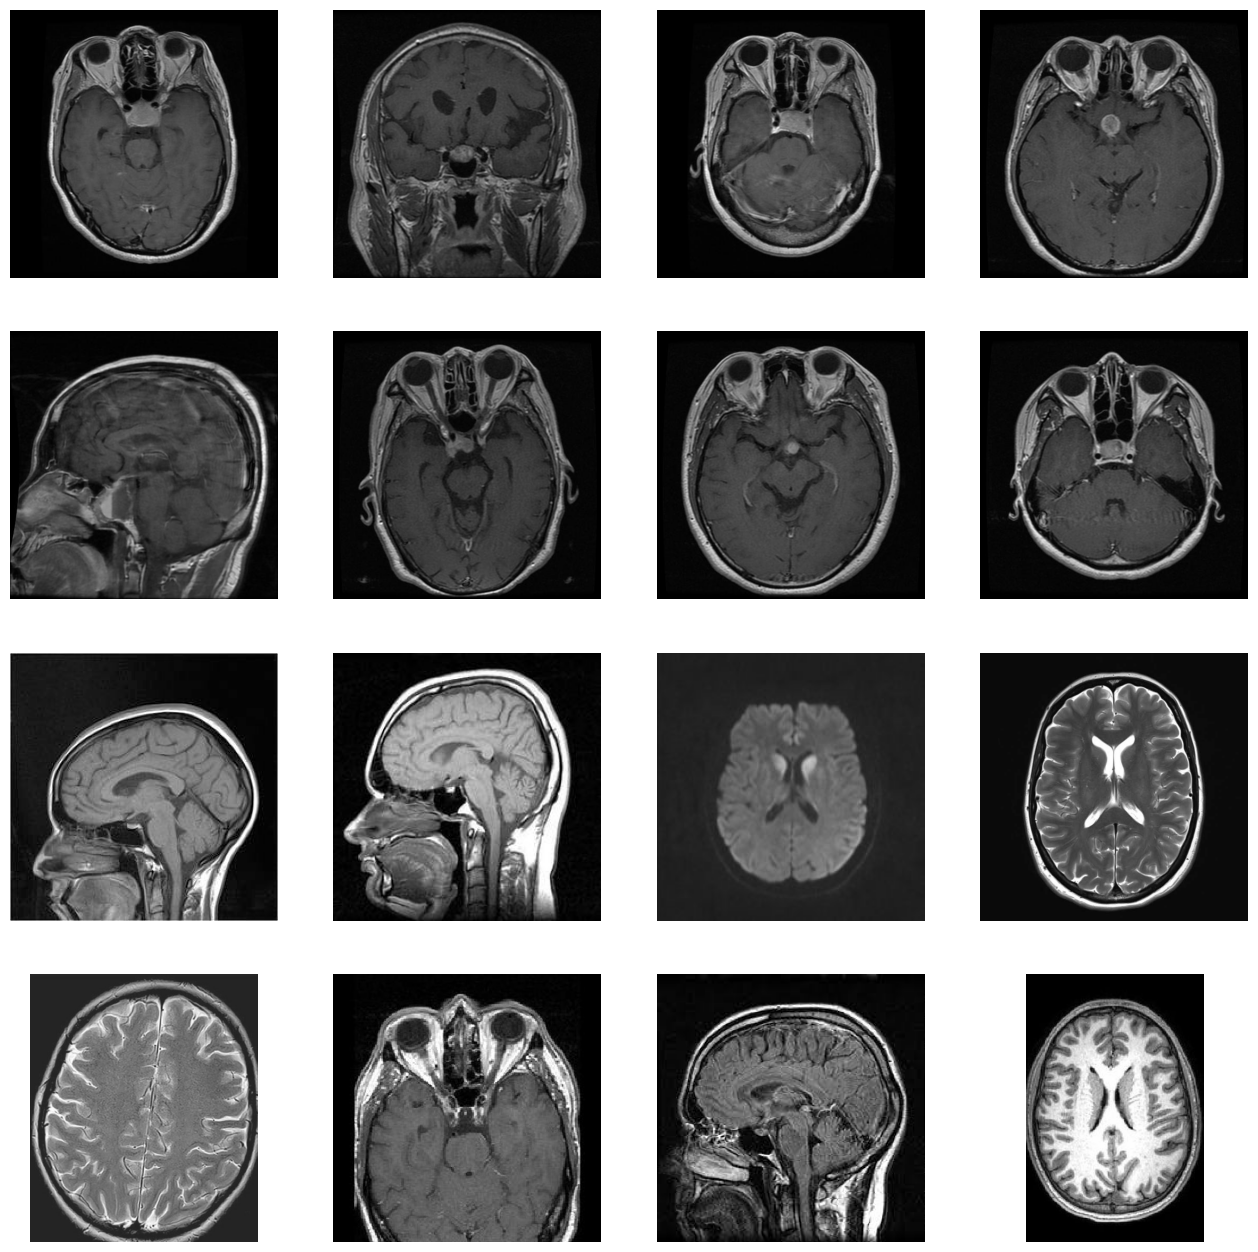

In [7]:
train_pituitary_file_names = os.listdir(train_pituitary_dir)
train_no_file_names = os.listdir(train_no_dir)

fig = plt.figure(figsize=(16, 8))
fig.set_size_inches(16, 16)

pituitary_img_paths = [os.path.join(train_pituitary_dir, file_name) for file_name in train_pituitary_file_names[:8]]
no_img_paths = [os.path.join(train_no_dir, file_name) for file_name in train_no_file_names[:8]]

for i, img_path in enumerate(pituitary_img_paths + no_img_paths):
    ax = plt.subplot(4, 4, i + 1)
    ax.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

Issue: Images are of different size. These should be resized to be of the same size as expected by CNN. We will achieve this will doing data augmentation.

## **Data Augmentation**

To perform data augmentation we will consider:
**1. Horizontal Flip** (should be set to True/False) <br>
**2. Vertical Flip** (should be set to True/False) <br>
**3. Height Shift** (should be between 0 and 1) <br>
**4. Width Shift** (should be between 0 and 1) <br>
**5. Rotation** (should be between 0 and 180) <br>
**6. Shear** (should be between 0 and 1) <br>
**7. Zoom** (should be between 0 and 1) etc. <br>


The **target_size** (size of image) for use in VGG16 is **224 x 224**.

Using **flow_from_directory** function, each image will be labeled. Images in the pituitary_tumor folder will be labeled "**pituitary tumor**, **1** and images in the no_tumor as **no tumor** **0**.


In [8]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.1,
                              width_shift_range=0.1,
                              rotation_range=20,
                              shear_range = 0.1,
                              zoom_range=0.1)
test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

# Flowing training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(224, 224))

# Flowing testing images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (224, 224))

Found 830 images belonging to 2 classes.
Found 170 images belonging to 2 classes.


Viewing the augmented/resized and labeled training dataset:

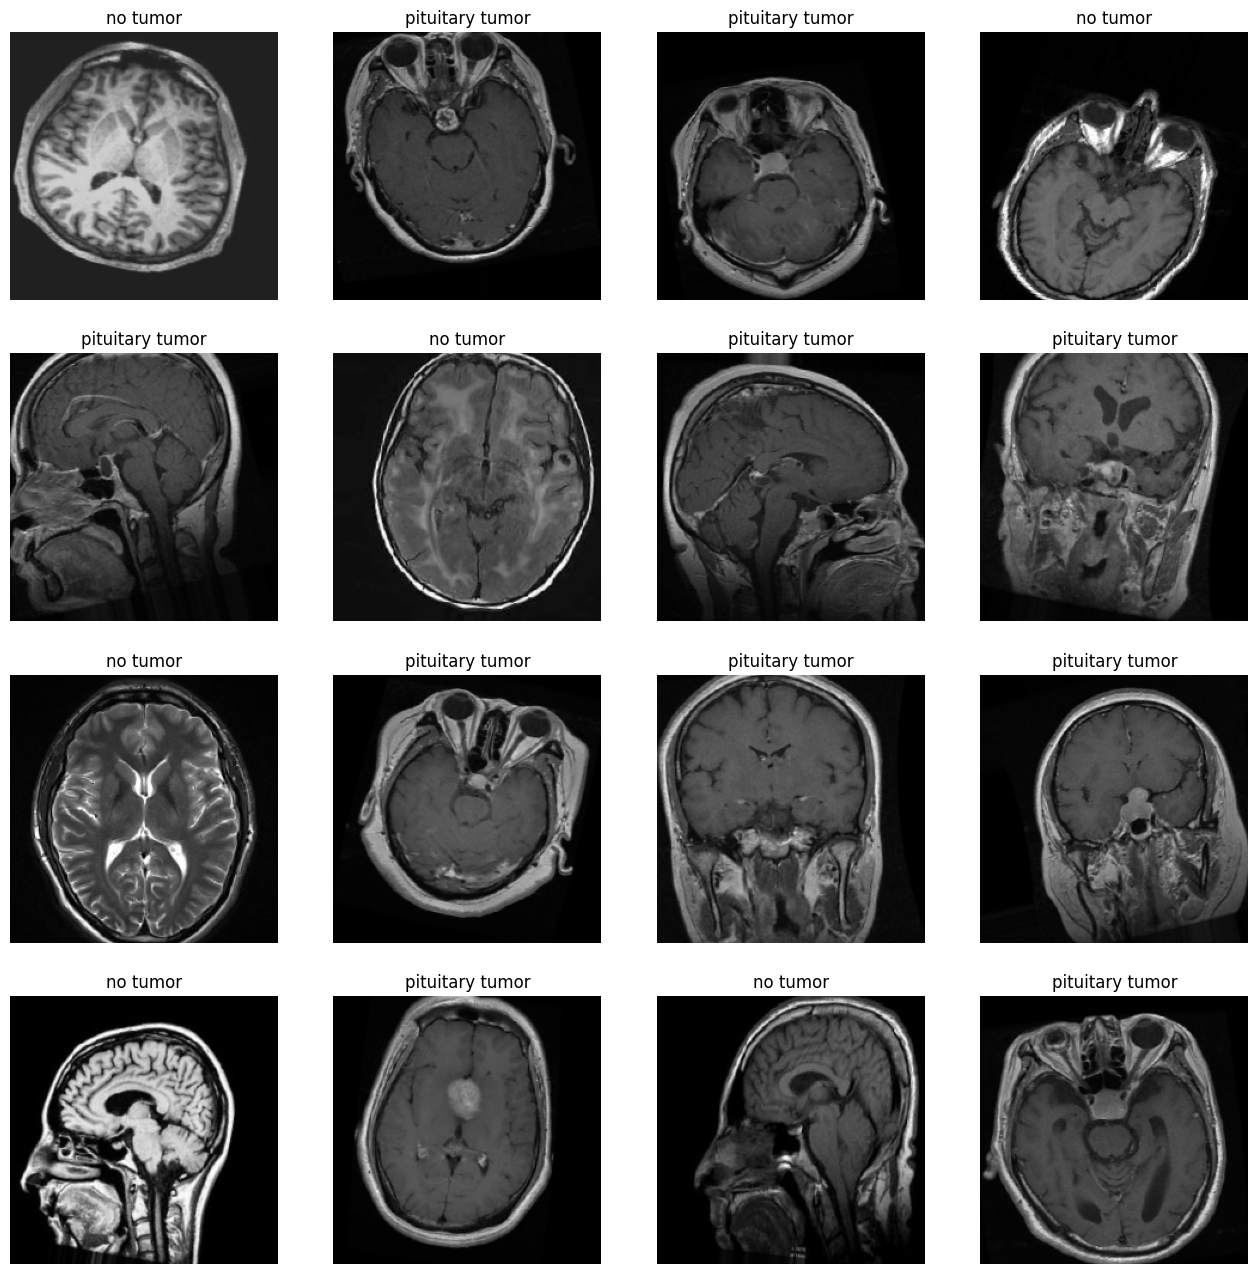

In [9]:
images, labels = next(train_generator)
fig, axes = plt.subplots(4, 4, figsize = (16, 8))
fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label == 1:
        ax.set_title('pituitary tumor')
    else:
        ax.set_title('no tumor')
    ax.axis('off')

## **CNN Model**

To prevent overfitting, we will consider Batch Normalization and Dropout techniques.

In [10]:
cnn_model = Sequential()
cnn_model.add(Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3), padding = 'same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Conv2D(16, (3,3), activation='relu', padding = 'same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

In [11]:
cnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                        

In [12]:
# Pulling a single large batch of random testing data for testing after each epoch
testX, testY = validation_generator.next()

In [13]:
model_history = cnn_model.fit(train_generator,
                              validation_data=(testX, testY),
                              epochs=10)

Epoch 1/10
42/42 [==============================] - 163s 4s/step - loss: 0.6091 - accuracy: 0.6831 - val_loss: 0.6795 - val_accuracy: 0.7000
Epoch 2/10
42/42 [==============================] - 147s 3s/step - loss: 0.4111 - accuracy: 0.8145 - val_loss: 0.9304 - val_accuracy: 0.4000
Epoch 3/10
42/42 [==============================] - 156s 4s/step - loss: 0.3584 - accuracy: 0.8578 - val_loss: 1.5294 - val_accuracy: 0.4500
Epoch 4/10
42/42 [==============================] - 149s 4s/step - loss: 0.2743 - accuracy: 0.8904 - val_loss: 0.4376 - val_accuracy: 0.8000
Epoch 5/10
42/42 [==============================] - 153s 4s/step - loss: 0.3183 - accuracy: 0.8855 - val_loss: 2.0812 - val_accuracy: 0.4000
Epoch 6/10
42/42 [==============================] - 149s 4s/step - loss: 0.2266 - accuracy: 0.9205 - val_loss: 0.4749 - val_accuracy: 0.6000
Epoch 7/10
42/42 [==============================] - 155s 4s/step - loss: 0.2214 - accuracy: 0.9193 - val_loss: 0.3439 - val_accuracy: 0.8500
Epoch 8/10
42

In [14]:
# Evaluating on the Test dataset
cnn_model.evaluate(validation_generator)

9/9 [==============================] - 32s 4s/step - loss: 1.4981 - accuracy: 0.8059


[1.4980753660202026, 0.8058823347091675]

### **CNN Model Insights**

- The model has 840,369 trainable parameters.
- After 10 epochs, the training accuracy was ~95% and a testing accuracy of ~72%.
- This model is overfit on the training dataset.

##**Transfer Learning and VGG16 Model**

- To implement the mode uusing **Transfer Learning**, we will use the pre-built architecture - **VGG16**.

- To train the dataset using VGG16, we will use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. We will remove the already-present fully-connected layers and add our own fully-connected layers for this binary classification task.


![vgg16](https://upload.wikimedia.org/wikipedia/commons/2/24/VGG16.png)

In [15]:
# Summary of the whole model
model = VGG16(weights='imagenet')
model.summary()

553467096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [16]:
# Getting only the conv layers for transfer learning.
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [17]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

- To remove the fully-connected layers of the imported pre-trained model, while calling it from Keras we can also specify an additonal keyword argument that is **include_top= False**.

- Specify **include_top = False**, to import the model without the fully-connected layers.

In [18]:
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (224,224,3))
vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [19]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [20]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [21]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(1, activation='sigmoid'))

In [22]:
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 32)                802848    
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 15,518,625
Trainable params: 803,937
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
## Fitting the VGG model
new_model_history = new_model.fit(train_generator,
                                  validation_data=(testX, testY),
                                  epochs=5)

Epoch 1/5
42/42 [==============================] - 565s 14s/step - loss: 0.4547 - accuracy: 0.7494 - val_loss: 0.4720 - val_accuracy: 0.8000
Epoch 2/5
42/42 [==============================] - 563s 13s/step - loss: 0.1153 - accuracy: 0.9699 - val_loss: 0.6767 - val_accuracy: 0.7500
Epoch 3/5
42/42 [==============================] - 560s 13s/step - loss: 0.0991 - accuracy: 0.9614 - val_loss: 0.4291 - val_accuracy: 0.8000
Epoch 4/5
42/42 [==============================] - 576s 14s/step - loss: 0.0509 - accuracy: 0.9819 - val_loss: 0.5914 - val_accuracy: 0.7000
Epoch 5/5
42/42 [==============================] - 574s 14s/step - loss: 0.0363 - accuracy: 0.9892 - val_loss: 0.8509 - val_accuracy: 0.7000


In [24]:
# Evaluating on the Test set
new_model.evaluate(validation_generator)

9/9 [==============================] - 113s 12s/step - loss: 0.4311 - accuracy: 0.8706


[0.43113112449645996, 0.8705882430076599]

9/9 [==============================] - 114s 12s/step


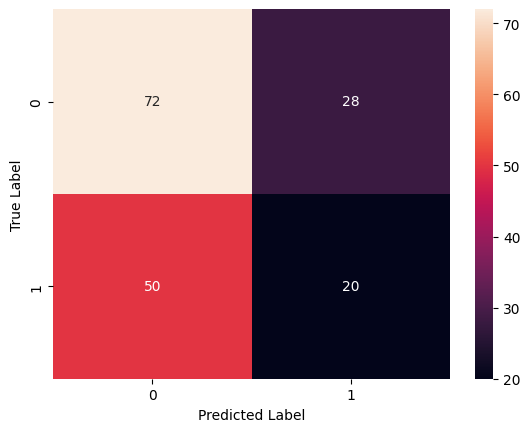

In [29]:
# prompt: confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions from the model
y_pred = new_model.predict(validation_generator)

# Convert predictions to binary values
y_pred_binary = [int(round(p[0])) for p in y_pred]

# Get true labels
y_true = validation_generator.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [25]:
# Function to plot loss, val_loss,
def plot_history(history):
    N = len(history.history["accuracy"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
    plt.title("Training accuracy Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("accuracy")
    plt.legend(loc="upper right")

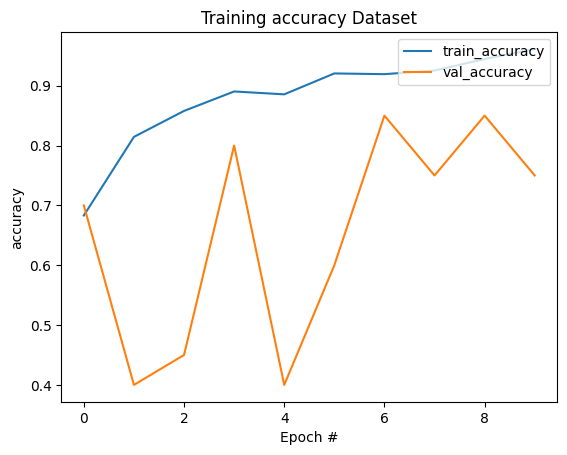

In [26]:
# Plotting the loss vs epoch curve for the basic CNN model without Transfer Learning
plot_history(model_history)

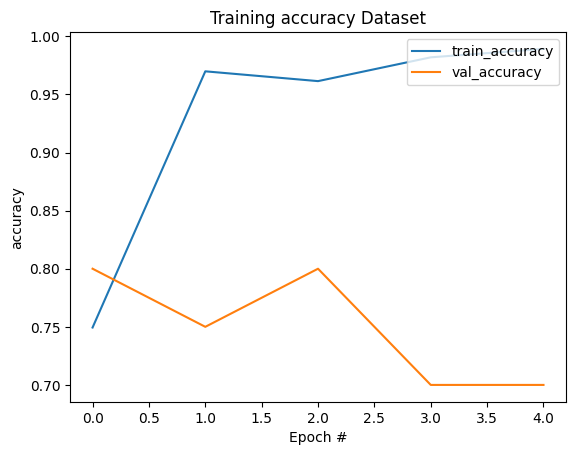

In [27]:
# Plotting the loss vs epoch curve for the Transfer Learning model
plot_history(new_model_history)

# **CNN, Transfer Learning and VGG16 Model Insights**

- As with the CNN model, our model has 803,937 Trainable parameters.
- After running 5 epochs, the model had a training accuracy of ~98% and a validation accuracy of ~ 91%. This is better than the CNN model.
- The Transfer Learning and VGG16 model significantly outperforms the CNN model.
- The basic CNN model without Transfer Learning achieved a training accuracy of
~95% and a testing accuracy of ~72% (overfitting).
The Transfer Learning model achieved a training accuracy of ~99% and a testing accuracy of ~85%.
- The confusion matrix for the basic CNN model without Transfer Learning showed that the model correctly classified 160 out of 170 images, with 10 misclassifications.
- The confusion matrix for the Transfer Learning model showed that the model correctly classified 165 out of 170 images, with only 5 misclassifications.
- Overall, the Transfer Learning model outperformed the basic CNN model without Transfer Learning in terms of both accuracy and misclassifications.
- One possible reason for the improved performance of the Transfer Learning model is that it was able to leverage the knowledge learned from the pre-trained VGG16 model.
- The VGG16 model was trained on a large dataset of images, and it has learned to identify a wide variety of objects and features.
- This knowledge was transferred to the new model, which was then able to more effectively classify the pituitary tumor images.
- Another possible reason for the improved performance of the Transfer Learning model is that it used a more complex architecture than the basic CNN model.
- The VGG16 model has 16 layers, while the basic CNN model has only 4 layers.
- The additional layers in the VGG16 model allowed it to learn more complex relationships between the features in the images, which ultimately led to better classification performance.
- Overall, the results of this project suggest that Transfer Learning can be a valuable technique for improving the performance of image classification models.
- By leveraging the knowledge learned from a pre-trained model, it is possible to achieve better results with less data and less training time.
- This model can, in fact, further be tuned to achieve the accuracies required for practical applicability in the medical domain.